In [42]:
from accelerate import Accelerator
import json 
import os 
from typing import Dict, Any


def load_config(config_path: str) -> Dict[str, Any]:
    """Load configuration from JSON file."""
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    # Flatten config for easier access
    flat_config = {}
    flat_config.update(config['evaluation'])
    flat_config.update(config['model'])
    flat_config.update(config['dataset'])
    
    return flat_config

accelerator = Accelerator()
device = accelerator.device

config = load_config('eval_config.json')
print('model_path', config['model_path'])
print('result_path', config['results_path'])

model_path ./checkpoints/firm-disco-25/maskgen_epoch_0_batch_2500
result_path ./new_results/maskgen_multi_kl1


In [43]:
from maskgen.utils.save_utils import load_pixel_heatmap_pairs
npz_path = os.path.join(config['results_path'],'pixel_heatmap_pairs.npz')
dataloader = load_pixel_heatmap_pairs(npz_path, batch_size=1, shuffle=False)

In [44]:
from maskgen.evaluation import EvalGame
from maskgen.utils.model_utils import get_pred_model
import numpy as np

processor, pred_model = get_pred_model(config['pretrained_name'], device)
pred_model.eval() 
target_model = lambda x: pred_model(x).logits

eval_game = EvalGame(target_model)


del_score_list = []
ins_score_list = []
cum_del_score = 0
cum_ins_score = 0
for idx, batch in enumerate(dataloader):
    pixel_values = batch['pixel_values'].to(device)
    heatmaps = batch['heatmap'].to(device)
    del_score = eval_game.get_deletion_score(pixel_values, heatmaps)
    ins_score = eval_game.get_insertion_score(pixel_values, heatmaps)
    del_score_list.append(del_score)
    ins_score_list.append(ins_score)
    cum_del_score += del_score.item()
    cum_ins_score += ins_score.item()
    print(f'Batch {idx} - Del AUC: {del_score:.4f}, Ins AUC: {ins_score:.4f}')
    print(f'Current Del AUC: {cum_del_score / len(del_score_list):.4f}, Current Ins AUC: {cum_ins_score / len(ins_score_list):.4f}')
    if idx == 100:
        break


Batch 0 - Del AUC: 7.7726, Ins AUC: 83.8784
Current Del AUC: 7.7726, Current Ins AUC: 83.8784
Batch 1 - Del AUC: 9.0997, Ins AUC: 87.6962
Current Del AUC: 8.4361, Current Ins AUC: 85.7873
Batch 2 - Del AUC: 16.3218, Ins AUC: 80.1228
Current Del AUC: 11.0647, Current Ins AUC: 83.8991
Batch 3 - Del AUC: 4.5103, Ins AUC: 29.7624
Current Del AUC: 9.4261, Current Ins AUC: 70.3649
Batch 4 - Del AUC: 23.4741, Ins AUC: 94.6679
Current Del AUC: 12.2357, Current Ins AUC: 75.2255
Batch 5 - Del AUC: 75.9787, Ins AUC: 88.7867
Current Del AUC: 22.8595, Current Ins AUC: 77.4857
Batch 6 - Del AUC: 13.8011, Ins AUC: 88.5246
Current Del AUC: 21.5654, Current Ins AUC: 79.0627
Batch 7 - Del AUC: 57.8926, Ins AUC: 83.2117
Current Del AUC: 26.1063, Current Ins AUC: 79.5813
Batch 8 - Del AUC: 23.9967, Ins AUC: 68.3841
Current Del AUC: 25.8719, Current Ins AUC: 78.3372
Batch 9 - Del AUC: 11.8861, Ins AUC: 82.4275
Current Del AUC: 24.4734, Current Ins AUC: 78.7462
Batch 10 - Del AUC: 22.9279, Ins AUC: 89.1931


In [45]:
import pandas as pd

result_dict = {'idx': range(len(del_score_list)), 
               'del_score': [x.item() for x in del_score_list], 
               'ins_score': [x.item() for x in ins_score_list]}

# Save results dict to pandas dataframe and save to csv
result_df = pd.DataFrame(result_dict)
result_df.to_csv(os.path.join(config['results_path'], 'eval_results.csv'), index=False)

# Hard cases

In [46]:
from maskgen.utils.save_utils import PixelHeatmapDataset

# # override npz_path
# npz_path = "./new_results/maskgen_unitvalue_kl1"
# npz_path = os.path.join(npz_path,'pixel_heatmap_pairs.npz')
dataset = PixelHeatmapDataset(npz_path)


Predicted class: barn spider, Araneus cavaticus


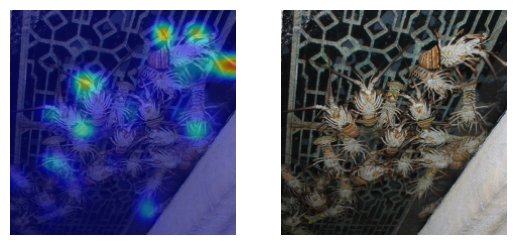

In [64]:
from maskgen.utils.img_utils import plot_overlap_np
import torch
# 55, 45, 44, 43, 40, 22, 26， 75*， 24
hard_sample = dataset[12]
image = hard_sample['pixel_values']
with torch.no_grad():
    img = image.to(device).unsqueeze(0)
    predicted_class_idx = pred_model(img).logits.argmax(-1).item()
    secondary_class_idx = pred_model(img).logits.argsort(descending=True)[0][1].item()

label = predicted_class_idx
# label = secondary_class_idx
label = torch.tensor([label]).to(device)

print("Predicted class:", pred_model.config.id2label[label.item()])


heatmap = hard_sample['heatmap']

image = image.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
heatmap = heatmap.squeeze(0).detach().cpu().numpy()

_, _ = plot_overlap_np(image, heatmap, processor.image_mean, processor.image_std)


In [63]:
print(heatmap.max(), heatmap.min()) 

0.977098 0.12634
